<h3 align="center">NEU 437/537</h3>
<h4 align="center">Princeton University, Spring 2022</h4>

---
## Homework 1: Short-term memory and decision-making
#### Due: Friday, Feb 18 

---
### Formatting Instructions
- Please prepare your homework submission completely within your own copy of this colab notebook.

- For each problem or sub-problem, please **limit yourself to one Code cell and/or one Markdown cell** as appropriate (switch between them by using the menu at the top, or the shortcuts `Ctrl+M M` for Markdown and `Ctrl+M Y` for Code). 

- **Submitting your homework**:  Please submit an .ipynb file via the assignment tab in Canvas. (From your notebook, File->Download->Download .ipynb).  Late submissions will be penalized 10% per day.

- **Test before submmitting**: Before submitting, make sure to verify that your code runs without  errors by selecting `Runtime -> Restart & Run All`. 


---
Setup: let's run a magic command (to force inline plotting) and then import some of our favorite packages.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

This week we will learn more about Mutual Inhibition models while also introducing a new concept: bifurcation. 

A major concept introduced in this class is that of an **attractor network**. In this week's paper (Wong et al., 2006), working memory is modeled by a network with multiple
stable points that can hold memories. Networks like this are sometimes called attractor
networks. When we say attractor, we really mean "certain points that the system is attracted to,
or repelled from." These certain points are known as **fixed points** in the dynamical systems
literature. They’re called fixed points because at this point, the derivative for all ODEs in the system are zero, and so a system at this point will stay at this point forever.
A fixed point is called **stable** if nearby points are attracted to it. A fixed point is called
**unstable** if nearby points are repelled from it. 

## Modeling Mutual Inhibition

**1a)** Consider two neurons receiving constant excitation and mutual inhibition. Let us model each neuron with the equation below, where $r_i$  is the firing rate of neuron $i$. The sigma sums over all inputs to that neuron.
$$\tau \frac{d r_{i}}{d t}=-r_{i}+f\left(\sum_{j} w_{i, j} r_{j}\right)$$

The function $f$ controls how the weighted sum of the pre-synaptic firing rates translates to the firing rate of the postsynaptic neuron. First, let's assume a rectified linear model where $f(x)=\max (0, x)$ (defined in `f_relu`)
In our simple network we only have one input for each neuron with weight $(-W)$ representing an inhibitory synapse. We will also model an external input $E$ that acts like a synapse onto each cell. We can rewrite the equations as a system of ordinary differential equations (ODEs)
$$
\begin{aligned}
\tau \frac{d r_{1}}{d t} &=-r_{1}+f\left(E-W r_{2}\right) \\
\tau \frac{d r_{2}}{d t} &=-r_{2}+f\left(E-W r_{1}\right)
\end{aligned}
$$



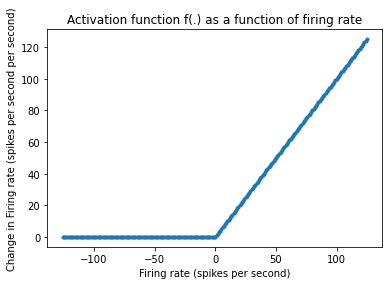

In [2]:
T   = 3         # maximum time to simulate
dt  = 1e-4      # timestep for the simulation

tau = 0.1       # time constant of the linear neurons
W = 0.85      # mutual-connection weight



E = 100        # Constant excitatory current, in Siemens
n1_init = 35    # initial firing rate for neuron 1
n2_init = 80    # initial firing rate for neuron 1

# Activation function
def f_relu(x):
    return np.maximum(0, x)

x = np.arange(-126,126, 1)
plt.title("Activation function f(.) as a function of firing rate")
plt.plot(x, f_relu(x), '.-')
plt.xlabel("Firing rate (spikes per second)")
plt.ylabel("Change in Firing rate (spikes per second per second)")
plt.show()

We make a plot of nullclines for this system. For each differential equation in the system of ODEs, the **nullcline** for that ODE is curve in $(r_1,r_2)$ space that will make the derivative vanish. e.g. The nullcline for neuron 1 is the curve in $(r_1,r_2)$ space such that $\tau \frac{d r_{1}}{d t}=0$

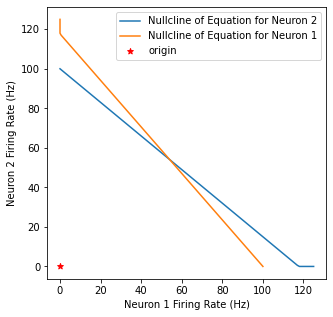

In [3]:

def plot_nullclines(E,W,f, title=None):
    R = np.arange(126) # range of inputs we'll test
    plt.figure(figsize=(5, 5))
    plt.title(title)
    plt.plot(R, f(E-W*R),label='Nullcline of Equation for Neuron 2')
    plt.plot(f(E-W*R), R,label = 'Nullcline of Equation for Neuron 1')
    plt.xlabel('Neuron 1 Firing Rate (Hz)')
    plt.ylabel('Neuron 2 Firing Rate (Hz)')
    plt.scatter(0, 0, marker="*",color='red', label="origin")
    plt.legend()
    plt.show()

plot_nullclines(E,W,f_relu)

The function `simulate_mutualinhibition` simulates the system of ODE using a simple Euler numerical integration algorithm

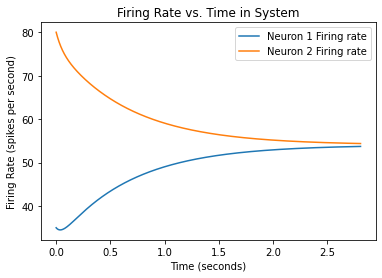

In [4]:
def simulate_mutualinhibition(T,W,E,dt,tau,n1_init,n2_init,f, 
                              plot=True, add_noise = 0, asymmetry = 0):
    """
    Simulate a system of two neurons (modeled by 2 ODEs) 
    returns firing rate of both neurons in spikes/sec.

    Arguments

    T         time to end simulation, in seconds
    W         weight of neuron connection (unit depends)
    E         mean excitatory input to both neurons
    dt        time step of simulations
    tau       membrane time constant, in seconds
    n1_init   initial firing rate of neuron 1
    n2_init   initial firing rate of neuron 2
    f         activation function of firing rate

    Optional keyword arguments:
    
    plot      whether to plot firing rates as a function of time
    add_noise whether to add noise to dynamics
    asymmetry whether to add an asymmetry to excitatory inputs of both neurons
    """
    t   = np.arange(0, T, dt) # A time vector
    N   = t.shape[0]          # number of timesteps

    rate1  = np.zeros(N) # A vector in which we'll store "firing rate" as a function of time
    rate2  = np.zeros(N) # A vector in which we'll store "firing rate" as a function of time

    # Initial Firing Rates
    rate1[0] = n1_init   # initial firing rate for neuron 1
    rate2[0] = n2_init   # initial firing rate for neuron 2

    # Run simulation
    for k in range(1, N):
        f1 = f(E + asymmetry - W*rate2[k-1]);   # input is W*rate, output is 9.1e10 times input
        f2 = f(E - asymmetry - W*rate1[k-1]);   # input is W*rate, output is 9.1e10 times input

        # Simple Euler numerical integration
        rate1[k] = rate1[k-1] + (dt/tau)*(-rate1[k-1] + f1) + np.random.randn() * add_noise
        rate2[k] = rate2[k-1] + (dt/tau)*(-rate2[k-1] + f2) + np.random.randn() * add_noise

        # If the network is stable then stop simulating
        if(abs(rate1[k] - rate1[k-1]) + abs(rate2[k] - rate2[k-1]) < 1e-4):
            break

    # Plot the first k time steps (i.e. up to when the network stopped simulating)
    if plot:
        plt.plot(t[:k], rate1[:k],label="Neuron 1 Firing rate")
        plt.plot(t[:k], rate2[:k],label="Neuron 2 Firing rate")
        plt.xlabel("Time (seconds)")
        plt.ylabel("Firing Rate (spikes per second)")
        plt.title("Firing Rate vs. Time in System")
        plt.legend()
        plt.show()
    return rate1, rate2, k


rate1, rate2, k = simulate_mutualinhibition(T,W,E,dt,tau,
                                            n1_init,n2_init,f_relu)

In [5]:
rate1[k]

53.72078349271456

Run the code above to simulate this model. Change the initial firing rates and the weights. Explain what you see. Specifically:
* For the current parameter settings, what are the fixed points in the network? How would you estimate by eye the fixed point of the network by looking at the firing rates vs. time plot? How would you estimate by eye the fixed points of the network by looking at the plot of the nullclines. **(1 point)**

<font color="red"> The system has a fixed point at ~(54,54).  
    
$$r_1 = r_2 = \frac{E}{W+1}  = 54.05$$
1. We recognize the fixed point(s) in a system by identifying the intersection(s) of the nullclines in a phase portrait.
2. The temporal plot supports this observation through he saturation of both firing rate lines at 53.72, illustrating that the fixed point is stable. </font>


* Set $W$ to values less than, equal to, or greater than $1 $, respectively. How many fixed points are there in each case? What is the relationship between the firing rates of both neurons at the fixed points? If you increase $W$ (but still keep $W$ within this range), how does this affect the firing rates for both neurons?  **(2 points)**

<font color="red"> - **0 < W < 1:** This range yields one fixed point. At W=0, the nullclines seem to be orthogonal and a W increases (and approaches 1) they getting closer to a mutual direction. Their intersection seems to reduce in value (somewhat symmetrically for both neurons) as W moves from 0 to 1.
- **W = 1:** The nullclines seem to be overlapping.
- **W > 1:** There seem to be three fixed points. Looking at this plot alone, I can not determine the type of these fixed points. Nonetheless, I can see that one maintains a symmetrical value for both neurons while in the other two, one neuron is large, and the other approaches 0.
    
    
 See supporting plots below </font>


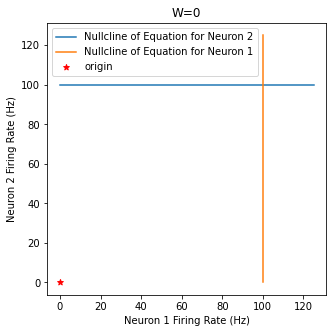

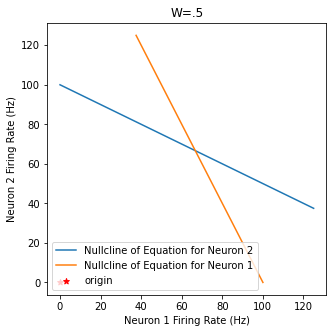

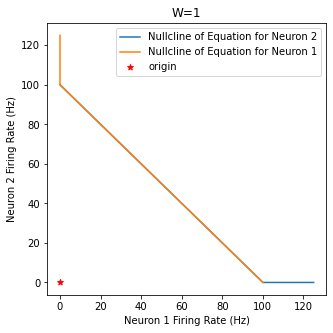

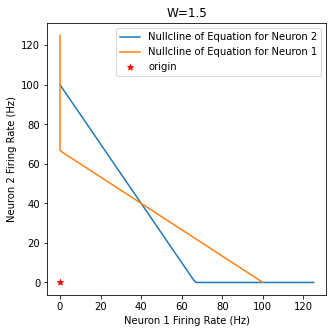

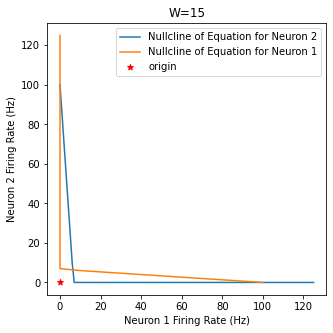

In [6]:
plot_nullclines(E,0,f_relu, 'W=0')
plot_nullclines(E,0.5,f_relu, 'W=.5')
plot_nullclines(E,1,f_relu, 'W=1')
plot_nullclines(E,1.5,f_relu, 'W=1.5')
plot_nullclines(E,15,f_relu, 'W=15')

* Now, we will linearize the dynamics around the $r_{1}=r_{2}$ fixed point. Our system of ODE is nonlinear (since `f_relu` is nonlinear), which makes this system hard to analyze as is. Linearization is a way to approximate the behavior
of a nonlinear system with the best available linear one. First, you have to compute the Jacobian of the system. The Jacobian matrix of the system is the matrix of partial derivatives 
$$ J(r_1,r_2)=\left[\begin{array}{ll}
\frac{\partial r_1^{\prime}}{\partial r_1} & \frac{\partial r_1^{\prime}}{\partial r_2} \\
\frac{\partial r_2^{\prime}}{\partial r_1} & \frac{\partial r_2^{\prime}}{\partial r_2}
\end{array}\right]$$
where we define new variables $$ \begin{aligned}
r_1^{\prime} = \frac{d r_{1}}{d t}\\
r_2^{\prime} = \frac{d r_{2}}{d t}
\end{aligned} $$ 
i.e. Differentiate the ODE system with respect to $r_1, r_2$ respectively.
If you are unsure how to do this, watching this video might help: https://www.youtube.com/watch?v=R1zXDFFxZHI&feature=youtu.be 
Evaluate the expression for the Jacobian at the fixed point $r_{1}=r_{2}$. **(2 points)**




<font color="red"> 


      
Linearizing : 
$ \tau \frac{d r_1}{d t}=\frac{(-r_1+E-Wr_2)}{\tau}$
    
    
$$ r_1^{\prime} = \frac{d r_1}{d t}=\frac{-r_1+E-W r_2}{\tau}\\
 r_2^{\prime} = \frac{d r_2}{d t}=\frac{-r_2+E-W r_1}{\tau}$$

Thus:
$$\frac{\partial r_1^{\prime}}{\partial r_1} = -\frac{1}{\tau}\\
\frac{\partial r_1^{\prime}}{\partial r_2} = -\frac{W}{\tau}\\
\frac{\partial r_2^{\prime}}{\partial r_1} = -\frac{W}{\tau}\\
\frac{\partial r_2^{\prime}}{\partial r_2} = -\frac{1}{\tau}
$$
    
    
$$ 
J(r_1,r_2)=\left[\begin{array}{ll}
\frac{\partial r_1^{\prime}}{\partial r_1} = -\frac{1}{\tau}  & \frac{\partial r_1^{\prime}}{\partial r_2} = -\frac{w}{\tau}  \\
\frac{\partial r_2^{\prime}}{\partial r_1} = -\frac{w}{\tau}   & \frac{\partial r_2^{\prime}}{\partial r_2} = -\frac{1}{\tau}
\end{array}\right]
$$    

</font>

* Compute the eigenvalues $\lambda(W, \tau)$ of the Jacobian as a function of $W$ and $\tau$. **(1 point)**

<font color="red">$$ J(r_1, r_2)=\left[\begin{array}{ll}
 -\frac{1}{\tau}-\lambda  & -\frac{w}{\tau}  \\
-\frac{w}{\tau}   &-\frac{1}{\tau}-\lambda 
\end{array}\right] = 0$$
   
$$
(\frac{1}{\tau}+\lambda )^2 - (\frac{W}{\tau})^2 =0\\
\frac{1}{\tau^2} + 2\frac{\lambda}{\tau} + \lambda^2 - \frac{W^2}{\tau^2} =0\\
\lambda^2 + \lambda\frac{2}{\tau} + \frac{1}{\tau^2}- \frac{W^2}{\tau^2} =0\\
\tau^2\lambda^2 + 2\tau\lambda + 1- W^2 =0\\
\lambda = \frac{-2\tau \pm \sqrt{4\tau^2 - 4\tau^2(1-W^2)}}{2\tau^2}\\
\lambda = \frac{-1 \pm W}{\tau}
$$ </font>


*  A fixed point is **stable** if all eigenvalues of the Jacobian are negative. A fixed point is **unstable** if at least one eigenvalue of the Jacobian is non-negative. For each case $W < 1, W=1, W>1$, determine whether the fixed point $r_{1}=r_{2}$ is stable or unstable. **(1 point)**

For more information on why this is the case, read [this article](https://eng.libretexts.org/Bookshelves/Industrial_and_Systems_Engineering/Book%3A_Chemical_Process_Dynamics_and_Controls_(Woolf)/10%3A_Dynamical_Systems_Analysis/10.04%3A_Using_eigenvalues_and_eigenvectors_to_find_stability_and_solve_ODEs)  or [this Stackoverflow post](https://physics.stackexchange.com/questions/143521/understanding-the-jacobian-matrix)

<font color="red">
    
$\lambda = \frac{-1 \pm W}{\tau}, \tau>0$
 
$W=1$: **unstable**
$$\lambda_1 = \frac{-1 + 1}{\tau} = 0\\
\lambda_2 = \frac{-1 - 1}{\tau}= \frac{-2}{\tau} < 0
$$ 
    
$W>1$: **unstable**
$$\lambda_1 = \frac{-1 + 2}{\tau} = \frac{1}{\tau} > 0\\
\lambda_2 = \frac{-1 - 2}{\tau}= \frac{-3}{\tau} < 0
$$ 
    
$W<1$:  **stable**
$$\lambda_1 = \frac{-1 + .5}{\tau} =  \frac{-.5}{\tau} < 0\\
\lambda_2 = \frac{-1 - .5}{\tau} = \frac{-1.5}{\tau} < 0
$$ 

</font>

**1b)** Now let's turn to spiking neurons. Consider an integrate-and-fire neuron whose membrane potential $V(t)$ follows the following differential equation: $$ C \frac{d V(t)}{d t}=\left(E_{l e a k}-V(t)\right) g_{l e a k}+I_{i n} $$ 

$V(t)$ emphasizes that the membrane potential is a function of time.

If $V>E_{\text {thresh }}$, then the neuron spikes and then set $V=E_{\text {reset }}$ 

If last spike occurred less than $\tau$ ago, then fix $V=E_{\text {reset }}$ 

We use the parameter values
1.  $\tau=1 \mathrm{~ms}$
2. $C=1 \mathrm{nF}$
3. $g_{\text {leak }}=50 \mathrm{nS}$
4. $E_{\text {leak }}=-60 \mathrm{mV}$
5. $E_{\text {reset }}=-60 \mathrm{mV}$
6. $E_{\text {thresh }}=-50 \mathrm{mV}$
7. constant $I_{in}$

* Suppose that the neuron has spiked at time $t=0$, so that $V(0)=E_{\text {reset }}$. Verify that the solution to this ODE is $$V(t)= \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) +\frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}$$
Verify that this solution satisfies the initial condition $V(0)=E_{\text {reset }}$ **(1 point)**



<font color="red">

$$V(t)= \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) +\frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}$$

Let's derive:
$$\frac{dV(t)}{dt}= (-\frac{g_{\text {leak }}}{C})\left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) $$

Assign $t=0, V(t) = E_{\text {reset }}$:
    
 $$\frac{dV(t)}{dt}= (-\frac{g_{\text {leak }}}{C})\left ( V(t) -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) * 1 $$   
    
$$C\frac{dV(t)}{dt}= (-g_{\text {leak }})\left ( V(t) -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right )  $$  
    
$$ C \frac{d V(t)}{d t}=\left(E_{l e a k}-V(t)\right) g_{l e a k}+I_{i n} $$     
</font>


* Show that the steady state voltage of this neuron, if there were no spiking, given an input $I_{in}$, is given by **(1 point)**

$$V_{\infty}(I_{in})=\frac{I_{i n}}{g_{l e a k}}+E_{l e a k} $$ 


<font color="red"> 
    
$$V(\infty)= \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times \infty } {C }}\right ) +\frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}$$

$$\exp \left ( {- \frac {g_{leak} \times \infty } {C }}\right )=0$$
Thus,
    
$$V(\infty)= \frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}$$

</font>



* Show that the time it takes to go from $V=E_{reset}$ to $V=E_{thresh}$ is given by: **(1 point)** 

$$
\tau+\frac{C}{g_{l e a k}} \log \left(\frac{V_{\infty}(I_{in})-E_{r e s e t}}{V_{\infty}(I_{in})-E_{t h r e s h}}\right)
$$
Note that we model neurons as having a refractory period of length $\tau$. So that the neuron's membrane potential $V(t)$ is clamped at $E_{reset}$ until time $t=\tau$



<font color="red"> 
    
We know that  $V(0) = E_{\text {reset }}$, i.e $t=0$.

$$ t_{E_{\text {thresh }}}  - t_{E_{\text {reset }}} = \tau + t - 0$$
    
Let's find $t_{E_{\text {thresh }}}$   
    
$$V(t) = E_{\text {thresh }} = \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) +\frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}$$
      
$$ \left (E_{\text {thresh }}-\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }}\right )  = \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) $$
  
$$ \left (E_{\text {thresh }}-\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }}\right )\exp \left ( 0 \right ) = \left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right ) \exp \left ( {- \frac {g_{leak} \times t } {C }}\right ) $$
    
$$ \frac{\left (E_{\text {thresh }}-\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }}\right )}{\left ( E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} \right )} = \frac{\exp \left ( {- \frac {g_{leak} \times t } {C }}\right )}{\exp \left ( 0 \right )} $$ 
    
$$ log\left ( \frac{E_{\text {thresh }}-\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }}}{ E_{\text {reset }} -\frac{I_{\text {in }}}{g_{\text {leak }}}-E_{\text {leak }} } \right )=  {- \frac {g_{leak} \times t } {C }} - 0 $$
   
    
Assigning the steady state values $V_{\infty}= \frac{I_{\text {in }}}{g_{\text {leak }}}+E_{\text {leak }}
$

$$ log\left ( \frac{E_{\text {thresh }}-V_{\infty}}{ E_{\text {reset }} -V_{\infty}} \right )=  {- \frac {g_{leak} \times t } {C }} - 0 $$

$$ t = \frac{C}{g_{leak}}log\left ( \frac{V_{\infty}-E_{\text {thresh }}}{ V_{\infty}-E_{\text {reset }} } \right )   $$    
   
Thus :
    
$$ t_{E_{\text {thresh }}} - t_{E_{\text {reset }}} = \tau + \frac{C}{g_{leak}}log\left ( \frac{V_{\infty}-E_{\text {thresh }}}{ V_{\infty}-E_{\text {reset }} } \right )  - 0 = $$
    
    
$$\tau + \frac{C}{g_{leak}}log\left ( \frac{V_{\infty}-E_{\text {thresh }}}{ V_{\infty}-E_{\text {reset }} } \right ) $$    
</font>


* Show that therefore the firing rate (spikes per second) $f()$ of this neuron as a function of a constant input $I_{\text {in }}$ is given by: **(1 point)** $$ \begin{array}{c}  f\left(I_{i n}\right)=\left(\tau+\frac{C}{g_{l e a k}} \log \left(\frac{V_{\infty}-E_{r e s e t}}{V_{\infty}-E_{t h r e s h}}\right)\right)^{-1} \\ \text { Where in addition we define that if } V_{\infty} \leq E_{\text {thresh }} \text { then } f\left(I_{i n}\right)=0 \end{array} $$



<font color="red"> Let us define $\Delta T$ as the time difference (ms) between $V_{reset}$ and $V_{thresh}$. Given their definition, we expect to have a single spike during this time period. Thus, the spike rate, is the rate between the number of spikes (1) and the time period (as calculated above). To put together:


$$f(I) = \frac{1}{\Delta T} = \left(\tau+\frac{C}{g_{l e a k}} \log \left(\frac{V_{\infty}-E_{r e s e t}}{V_{\infty}-E_{t h r e s h}}\right)\right)^{-1} $$

</font>


**1c)** We are going to modify the activation $f()$ to represent the input/output function of our population of neurons represented in the mutual inhibition model. Notice that the $f()$ function (defined in `f_current`) is now defined over current. i.e. the input $x$ should be given in Siemens (whereas previously the input $x$ was defined over firing rate and receiving inputs in Hertz). We set $E=$ 4nS (i.e. $E=4\times 10^{-9}$; in the code) and set $W=60 \mathrm{pS} / \mathrm{Hz}$ (i.e. $W=60\times 10^{-12}$;). Note that before $W$ was a unitless value, but now it has units of $\mathrm{S} / \mathrm{Hz}$.

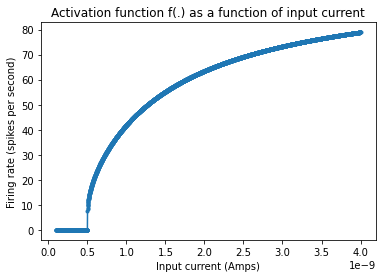

In [7]:
# Defining the input->output function for our integrate-and-fire neuron

def f_current(x, tau=0.01, C=1e-9, gl=50e-9, El=-60e-3, Er=-60e-3, Eth=-50e-3):
  """
  Given an input current x in Amps, returns firing rate of integrate-and-fire
  spiking neuron in spikes/sec.

  x can be a scalar or a numpy array.

  Optional keyword arguments:
  
  tau   membrane time constant, in seconds
  C     membrane capacitance, in Farads
  gl    membrane leak conductance, in Siemens
  El    leak potential, in Volts
  Er    post-spike reset potential, in Volts
  Eth   spike threshold, in Volts 
  """
  Vinf = x/gl + El;
  if hasattr(x, '__len__'):  # x is most likely a numpy array
    result = np.zeros_like(x)
    poss = np.where(Vinf > Eth)
    result[poss] = 1/( tau + (C/gl)*np.log( (Vinf[poss] - Er)/(Vinf[poss] - Eth) ))
  else:
    if Vinf < Eth:
      result = 0
    else: 
      result = 1/( tau + (C/gl)*np.log( (Vinf - Er)/(Vinf - Eth) ))

  return result


x = np.arange(0.1e-9, 4e-9, 1e-12)
plt.title("Activation function f(.) as a function of input current")
plt.plot(x, f_current(x), '.-')
plt.xlabel("Input current (Amps)")
plt.ylabel("Firing rate (spikes per second)")
plt.show()

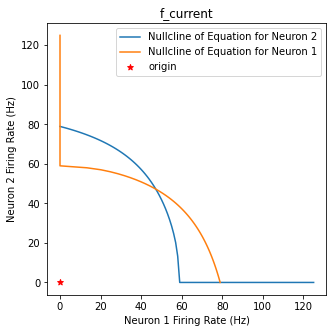

In [8]:
# help(f_current)

plot_nullclines(4e-9,6e-11,f_current, 'f_current')


- The following code plots the nullclines for the system with our new activation function `f_current`. How have the nullclines changed compared to the nullclines obtained with `f_relu`? Where do the nullclines cross? How many fixed points are there? **(2 points)**

<font color="red">f_current is a logReLU (rather than the original ReLU). The nullclines seem to have three fixed points. See plot above. </font>

- The plot also includes a velocity field for the system at different points in the phase plane. Note that this plot is not to scale, since velocity vectors that are very small have been scaled up in order to make clear their direction. Using this plot, determine whether the fixed points are stable or unstable. **(1 point)**

<font color="red"> Given the plot below, it seems that there are symetric stable points (attractors) at the bottom left and top right corners, and an unstable point (saddle) in the middle.  </font>


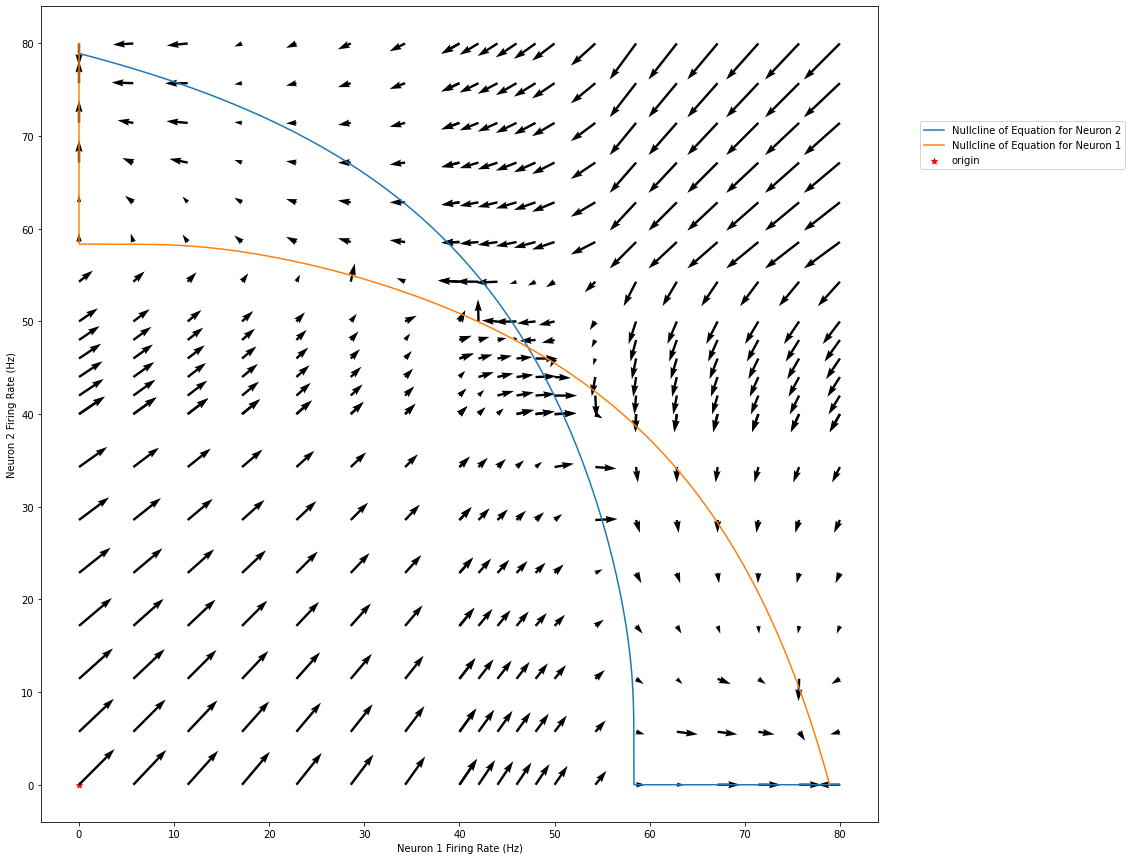

In [9]:


def plot_nullclines(E,W,f, fixedr1, fixedr2, asymmetry=0):
    plt.figure(figsize=(15,15))
    # Plot nullclines
    R = np.arange(0, 80, 0.01) # range of inputs we'll test
    plt.plot(R, f(E-W*R),label='Nullcline of Equation for Neuron 2')
    plt.plot(f(E-W*R), R,label = 'Nullcline of Equation for Neuron 1')
    plt.xlabel('Neuron 1 Firing Rate (Hz)')
    plt.ylabel('Neuron 2 Firing Rate (Hz)')
    plt.scatter(0, 0, marker="*",color='red', label="origin")
    plt.legend(loc=(1.05,.8))

    # Plot vector field
    xy = np.hstack((np.linspace(0,fixedr1,8),np.arange(fixedr1, fixedr2,2),np.linspace(fixedr2,80,8)))
    r1,r2 = np.meshgrid(xy,xy)
    u = -r1 + f(E + asymmetry - W*r2)
    v = -r2 + f(E - asymmetry - W*r1)
    u = np.where((u**2+v**2) > 250, u, u / np.sqrt(u**2+v**2) * 50)
    v = np.where((u**2+v**2) > 250, v, v / np.sqrt(u**2+v**2) * 50)

    plt.quiver(r1,r2,u,v)
    plt.show()

E= 4e-9  # we chose this frp 
W = 6e-11
plot_nullclines(E,W,f_current, 40, 50)

* Let us consider a system of 2 neurons that starts off at $(r_1=0,r_2=0)$. We will use `simulate_mutualinhibition` to simulate 100 trajectories from the system (while adding noise using the `add_noise` argument -- this gives the system variability so that we don't get the same phase plane trajectories every time). Comment on the stability of the fixed points and how this supports your answer in the previous question. **(1 point)**

<font color="red"> This graph presents the same data as the plot above. We see a divergence at the middle fixed point (i.e saddle) and a stability at the corner fixed points (i.e atractors)</font>


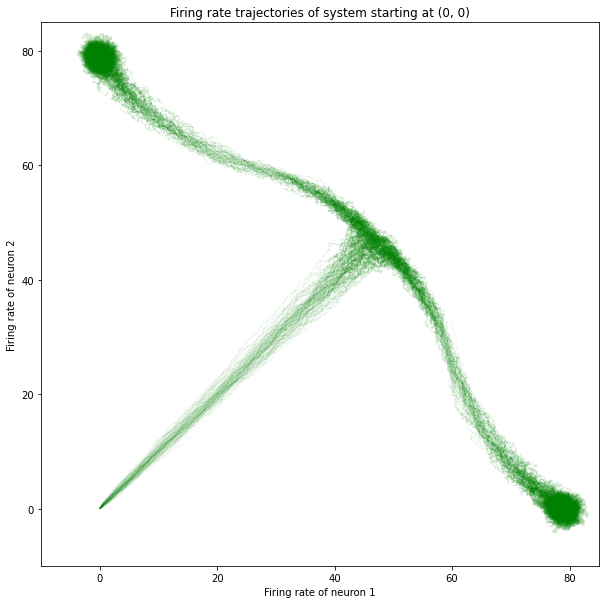

In [10]:
E= 4e-9  # we chose this frp 
W = 6e-11
plt.figure(figsize=(10,10))
for _ in range(100):
    rate1, rate2, k = simulate_mutualinhibition(T,W,E,dt,tau,n1_init=0,n2_init=0,
                                              f=f_current, plot=False, add_noise=0.05,
                                              asymmetry=0)
    plt.plot(rate1[:k], rate2[:k], color="green", alpha=0.2, linewidth=0.2)


plt.xlim(-10,85)
plt.ylim(-10,85)
plt.xlabel("Firing rate of neuron 1")
plt.ylabel("Firing rate of neuron 2")
plt.title("Firing rate trajectories of system starting at (0, 0)")
plt.show()

* Again, consider a system of 2 neurons that starts off at $(r_1=0,r_2=0)$. We will use `simulate_mutualinhibition` to simulate 100 trajectories with noise. We will add an extra parameter $a$ to the excitatory input of neuron 1 and subtract $a$ from the excitatory input of neuron 2. Recall that this system is modeled by
$$
\begin{aligned}
\tau \frac{d r_{1}}{d t} &=-r_{1}+f\left(E-W r_{2}\right) \\
\tau \frac{d r_{2}}{d t} &=-r_{2}+f\left(E-W r_{1}\right)
\end{aligned}
$$
With the parameter $a$ to the system, we write the system as
$$
\begin{aligned}
\tau \frac{d r_{1}}{d t} &=-r_{1}+f\left(E+a-W r_{2}\right) \\
\tau \frac{d r_{2}}{d t} &=-r_{2}+f\left(E-a-W r_{1}\right)
\end{aligned}
$$ This is implemented using the keyword argument `asymmetry` in the function `simulate_mutualinhibition`. 
What do you notice about the trajectories of this system? What might this asymmetry parameter $a$ represent biologically? **(2 points)**



<font color="red"> It seems that the proportion of the trajectories ending at each fixed points is asymmetric; there are more trajectiries ending at the bottom fixed point than at the top one.  </font>

<font color="red"> *a* can represent the asymteric connectivity strength allowing for asym excitation for neuron 1 or neuron 2 - can be more connections, more synaptic connections etc.</font>

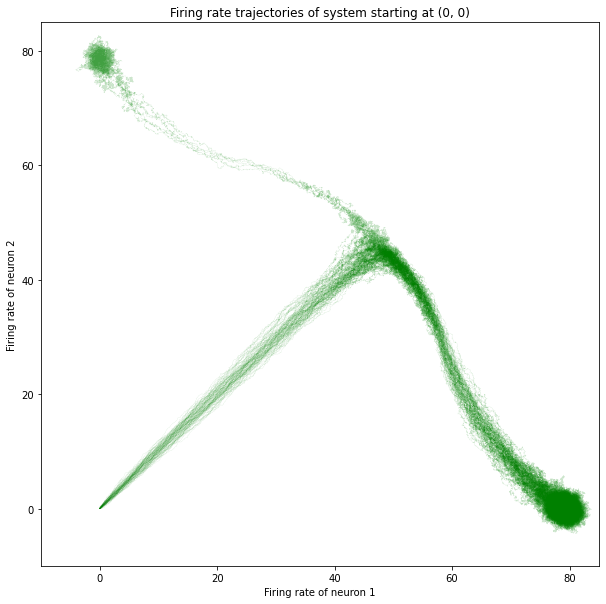

In [11]:
E= 4e-9  # we chose this frp 
W = 6e-11
plt.figure(figsize=(10,10))
for _ in range(100):
    rate1, rate2, k = simulate_mutualinhibition(T,W,E,dt,tau,n1_init=0,n2_init=0,
                                              f=f_current, plot=False, add_noise=0.05,
                                              asymmetry=4e-11)
    plt.plot(rate1[:k], rate2[:k], color="green", alpha=0.2, linewidth=0.2)


plt.xlim(-10,85)
plt.ylim(-10,85)
plt.xlabel("Firing rate of neuron 1")
plt.ylabel("Firing rate of neuron 2")
plt.title("Firing rate trajectories of system starting at (0, 0)")
plt.show()

* Now, we set $E=$ 3nS (i.e. $E=3\times 10^{-9}$) and set $W=36.5 \mathrm{pS} / \mathrm{Hz}$ (i.e. $W=36.5\times 10^{-12}$;). Again, we use `simulate_mutualinhibition` to simulate 100 trajectories, now without noise. We also remove the parameter $a$ from the excitatory input of both neurons. In the plot we show 100 trajectories of the system in green. The black points specify where the system was initialized, which are randomly distributed around $(40, 40)$ with standard deviation 15. The pink dots on the green trajectories represent equal-time interval snapshots of the system in time. How many attractors are there? Are they are stable or unstable? What happens to the dynamics of the system near these attractors? What types of variables might this network represent?  Further justify your answers by plotting the nullclines for this system. **(2 points)**

<font color="red"> It seems that there are 5 fixed points: Two corner stable points, and middle area of unstable points between them . This reflects a regimes with both a coexistence stability and a mutual exclusion, or mutual inhibition stability. See phase portrait below.  This kind of continual attractor can represent WM, where the stimulus is being held without extended intervention </font>


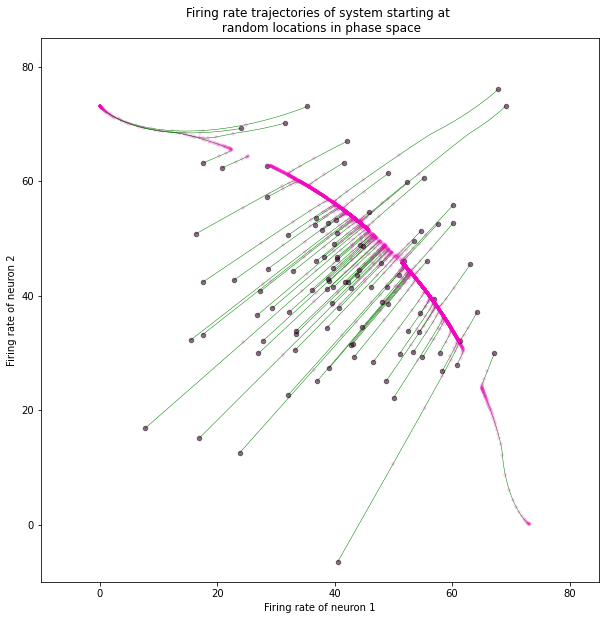

In [12]:
E = 3e-9
W = 3.65e-11
plt.figure(figsize=(10,10))
for _ in range(100):
    rate1, rate2, k = simulate_mutualinhibition(T,W,E,dt,tau,n1_init=np.random.randn() * 15 + 40,
                                             n2_init=np.random.randn() * 15 + 40,
                                              f=f_current, plot=False, add_noise=0.0,
                                              asymmetry=0)
    plt.scatter(rate1[[0]], rate2[[0]], color="black", s=20, alpha=0.5, zorder=2)
    plt.plot(rate1[:k], rate2[:k], color="green", alpha=1.0, linewidth=0.5, zorder=1)
    plt.scatter(rate1[0:k:350], rate2[0:k:350], color="#F507BF", s=20, 
                alpha=0.2, marker="+", zorder=2)


plt.xlim(-10,85)
plt.ylim(-10,85)
plt.xlabel("Firing rate of neuron 1")
plt.ylabel("Firing rate of neuron 2")
plt.title("Firing rate trajectories of system starting at \n random locations in phase space")
plt.show()

# PLOT THE NULLCLINES FOR THIS SYSTEM HERE

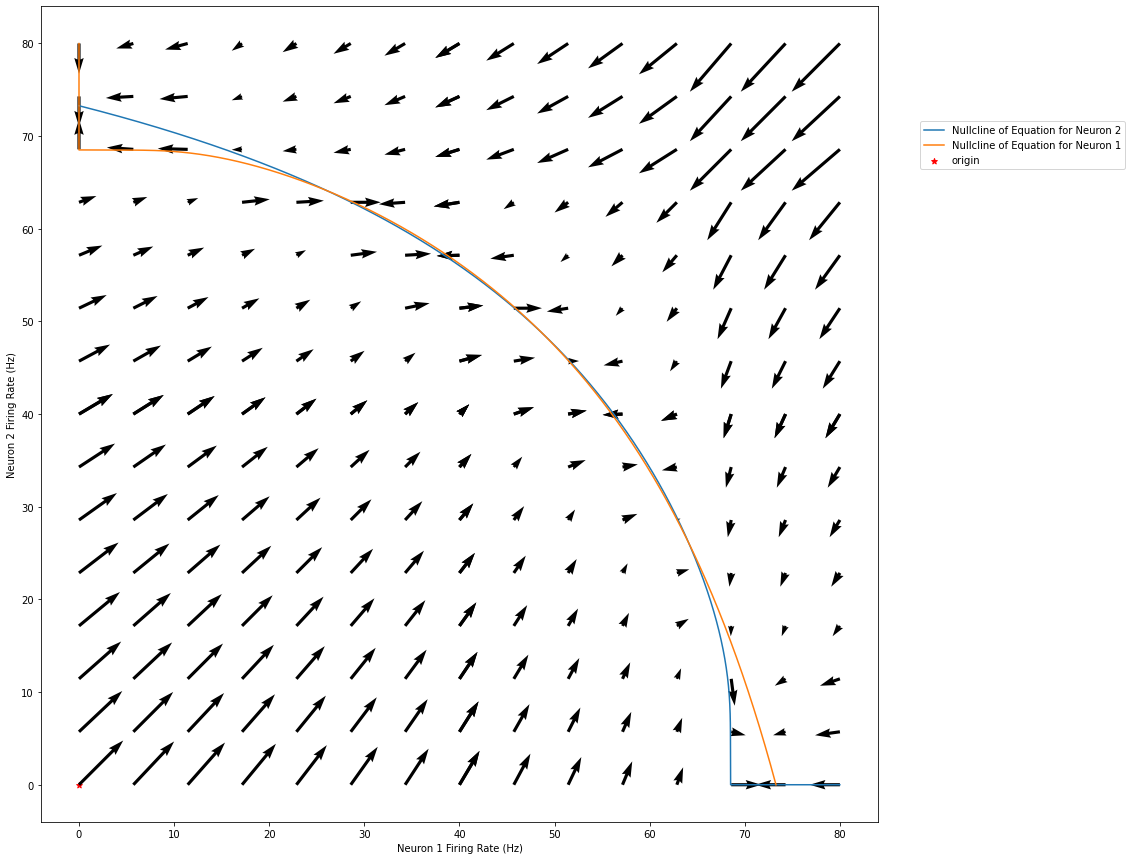

In [13]:
plot_nullclines(E,W,f_current, 40, 40)

* For the above parameter setting ($E=3\times 10^{-9}$  and $W=36.5\times 10^{-12}$), how robust are these parameters to error? e.g. What happens if $W$ is off this value by $5 \%$ ? Do the number of attractors and their stability change ? **(1 point)**

<font color="red"> This stat of the system is very fragile, even a 5% change to  𝑊  in each direction will result in a regime change, returting to a discrete collection of fixed points</font>

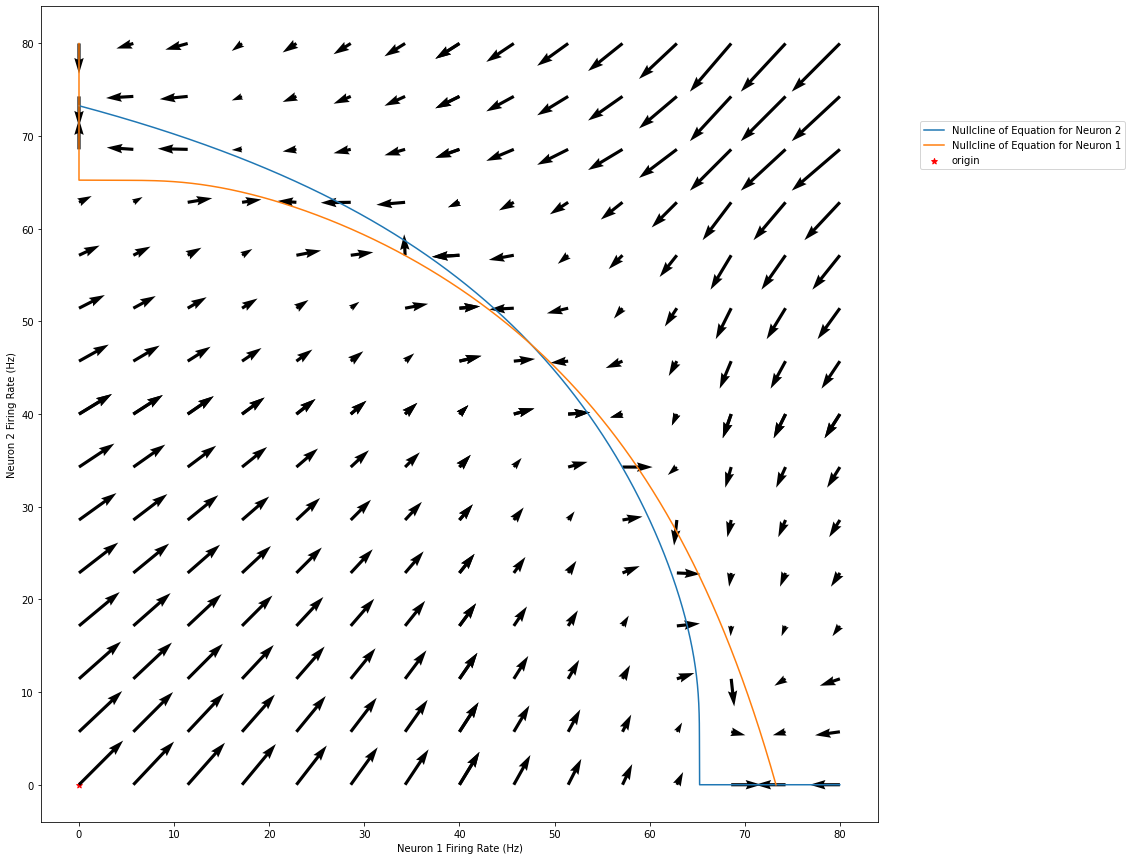

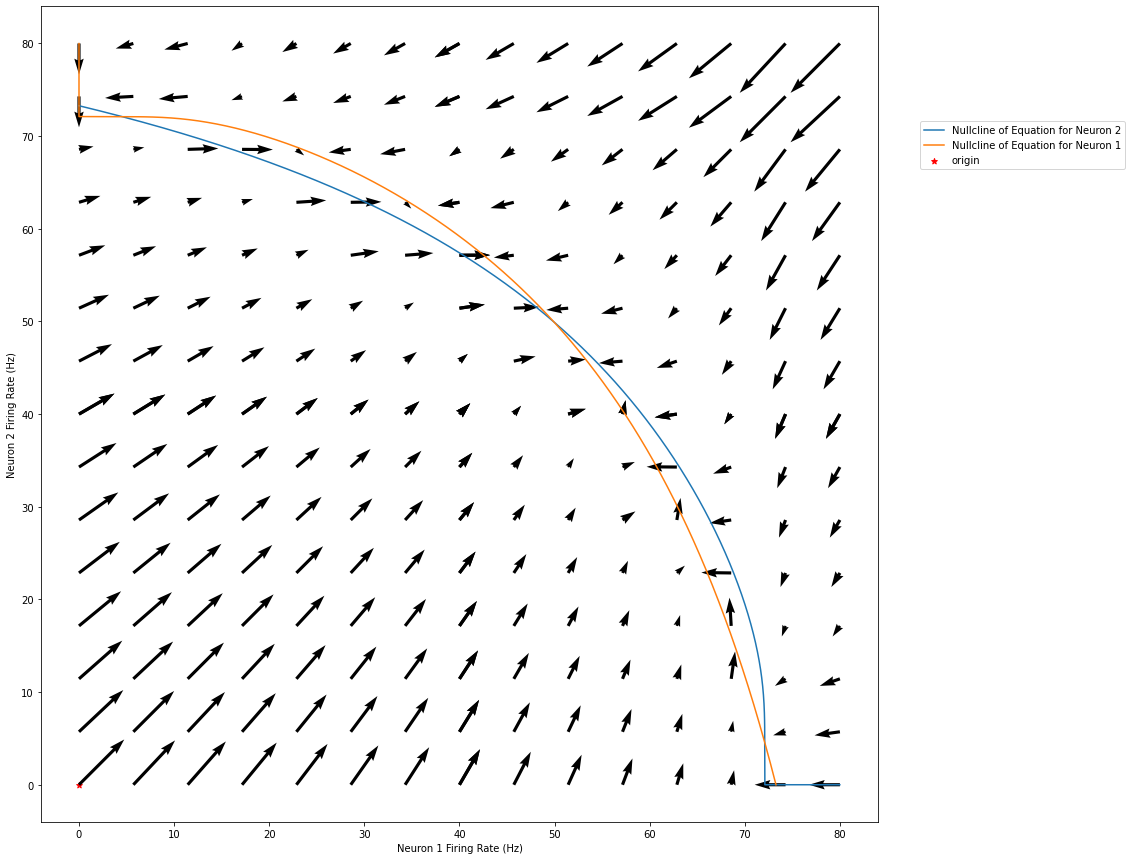

In [14]:
plot_nullclines(E,W+0.05*W,f_current, 40, 40)
plot_nullclines(E,W-0.05*W,f_current, 40, 40)

(For a paper that uses the fact that changes in parameters can easily drive the system between the regimes we've looked at above, see [Machens et al., *Science* 2005.](https://https://www.science.org/doi/10.1126/science.1104171))

---
## Exploring Bifurcations of Attractors


**Bifurcation** is the creation, destruction, or change
in stability of a fixed point. This problem will expose you to the idea of a bifurcation.

In class, we discussed the idea of memory being stored in an attractor network. Here, we will
consider a bistable attractor network, meaning it has two stable attractors the system could fall
into. Let's pretend this bistable attractor has to remember an upcoming choice (left or right). The
choice it needs to remember will be "set" by the initial value of $x$, (we will call it $x_{0}$ ). If $x_{0}<0$,
the choice should be left. If $x_{0}>0$, the choice should be right. We'll let the system run for a
short 'memory period.' 

After the memory period, if $x<0$ the choice will be left, and if $x>0$ the
choice will be right. $x_{0}$ might represent a sensory cue, or the output of an evidence
accumulation process, or some more complex cognitive process. 

Here is a simple 1-dimensional system that has the properties we would like: potential energy $V(x, a)$, and dynamics $\frac{d x}{d t}=f(x, a)=-\frac{d V}{d t}$ given by:
$$
\begin{array}{c}
V(x, a)=x^{4}-4 x^{2}+a(x-1)^{2}+5, \\
\frac{d x}{d t}=f(x, a)=-4 x^{3}+(8-2 a) x+2 a .
\end{array}
$$

**2a)** In this system $a$ is a parameter, which will be important later. Let's start by trying to understand what this system does. Call the function `bifnsim` below, with $a=0$. 
```
bifnsim(a=0)
```

`bifnsim` will simulate the system from 500 initial conditions, $x_{0}$, drawn from $[-2,2]$, and plot the outcome of the dynamics $\frac{d x}{d t}$ over a memory period of 1000 time steps. It will also plot the energy landscape $V(x, a)$. What happens? The system gets attracted towards two points. Attractors! One attractor is at a positive value, and it represents the "right" choice. The other attractor is at a negative value, and it represents the "left" choice. What determines which choice the system picks? The initial conditions $x_{0}$, which represents some sensory cue. We can find the position of the attractors by doing some simple math. A fixed point is a point where the dynamics do not change. That is, a point where the negative derivative of the potential $f(x, a) =-\frac{d V}{d t}=0$.
- Solve for the fixed points with $a=0$ (we will call the fixed points $x ^*$ ). **(2 points)**


Hopefully, you will find three fixed points. Wait! The simulations only showed two attractors! It turns out one of the fixed points is unstable.




<font color="red">

$$f(x,a) = -\frac{dV}{dt}=0\\
=-4x^3 +(8-2a)x +2a =0$$

Let $a=0$:
$$-4x^3 +8x=0\\
-4x(x^2-2)=0\\
-4x(x-\sqrt{2})(x+\sqrt{2})=0$$

$$x_1 = 0, x_2 = \sqrt{2}, x_3 = -\sqrt{2} $$
    
    
</font>

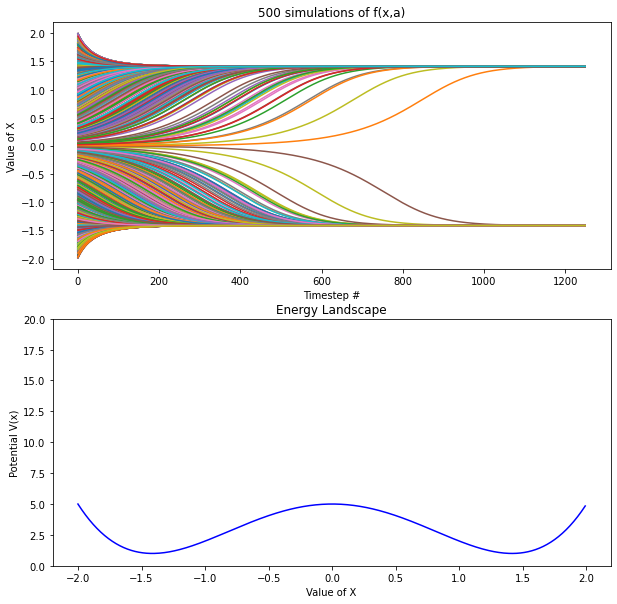

In [15]:
def bifnsim(a, saddle_point = False, plot=True):
    # Function Definitions
    f = lambda x, a: -4*x**3 + (8-2*a)*x + 2*a
    V = lambda x, a: x**4 - 4*x**2 + a*(x-1)**2 + 5

    # Parameters
    nTrials = 1000;                                  
    nSteps = 1250;
    dt = 0.001;

    # Initialize space
    x = np.zeros((nTrials, nSteps))
    x[:,0] = np.random.rand(nTrials) * 4 - 2 # Draw initial conditions
    if saddle_point == True:
        x[0, 0] = 0.0 # Place one initial condition at the unstable saddle node

    for i in range(nSteps-1):
        x[:, i+1] = x[:, i] + dt * f(x[:, i],a)
    
    if plot:
        fig, (ax0, ax1) = plt.subplots(2, figsize=(10,10))
        [ax0.plot(x[i]) for i in range(len(x))]
        ax0.set_ylabel('Value of X')
        ax0.set_xlabel('Timestep #')
        ax0.set_title('500 simulations of f(x,a)')

        x = np.arange(-2,2,0.01)
        ax1.plot(x, V(x,a),'b')
        ax1.set_ylabel('Potential V(x)')
        ax1.set_xlabel('Value of X')
        ax1.set_title('Energy Landscape');
        ax1.set_ylim([0, 20])
        plt.show()

    return x


_ =bifnsim(a=0)

**2b)** If you want to see the unstable fixed point in action, add the argument `saddle_point=True` to `bifnsim`. In this system, because there is no noise, if you start exactly at the unstable fixed point, you stay there forever.
- Determine the stability of the fixed points by evaluating if $\frac{d f}{d x}(x ^*, a=0)<0$ (stable), or $\frac{d f}{d x}(x ^*, a=0)>0$ (unstable). **(1 point)**

<font color="red"> $$f(x,a) = -4x^3 +(8-2a)x +2a\\
\frac{df}{dx} = -12x^2 +(8-2a)\\
\begin{align}
&\frac{df}{dx}(x=0, a=0) = -12*0 +8 = 8 &>0 \text{ (unstable)}\\
&\frac{df}{dx}(x=\sqrt{2}, a=0) = -12*2 +8 = -16 &<0 \text{ (stable)}\\
&\frac{df}{dx}(x=-\sqrt{2}, a=0) = -12*2 +8 = -16 &<0 \text{ (stable)}
\end{align}
$$ </font>

- Where are the stable and unstable fixed points with respect to the energy landscape, relative to nearby points? (Note the location of the unstable point determines how initial conditions will be "sorted" into the stable attractors.) **(1 point)**

<font color="red"> The stable points are the 'valleys' in the energy landscape and the unstable point is the middle 'hill'.</font>

- What would happen if that unstable point moved to a slightly negative value? **(1 point)**

<font color="red"> The symmtery of the regime will likely end, increasing to basin of attraction of the positive ('right') stable point </font>


**2c)** Now that we have some understanding of the system, let's try changing the parameter $a=1$ 

Our simulations look different, but it seems like we still have two attractors.

- Is the system still "sorting" initial conditions correctly into left/right choices, using the rule $x_{0}>0$ ? How does the accuracy of choices change? **(1 point)**

<font color="red"> Side-biased choices are more common when $a>0$</font>

- Did the unstable point move? Estimate its value now. **(1 point)**

- Did either of the attractors move? What are their values? Estimate their values now. **(1 point)**


<font color="red"> $$f(x,a=1) = -4x^3 +6x +2 =0\\
x = -1, \frac{1-\sqrt{3}}{2},  \frac{1+\sqrt{3}}{2}\\
\frac{df}{dx} = -12x^2 +6 =0\\
\begin{align}
&\frac{df}{dx}(x=-1, a=1) = -12*1 +6 = -6 &<0 \text{ (stable)}\\
&\frac{df}{dx}(x=\frac{1-\sqrt{3}}{2}, a=1) = -12*(\frac{1-\sqrt{3}}{2})^2 +6 = 4 &>0 \text{ (unstable)}\\
&\frac{df}{dx}(x=\frac{1+\sqrt{3}}{2}, a=1) = -12*(\frac{1+\sqrt{3}}{2})^2 +6 ~= -16 &<0 \text{ (stable)}
\end{align}$$
    
</font>





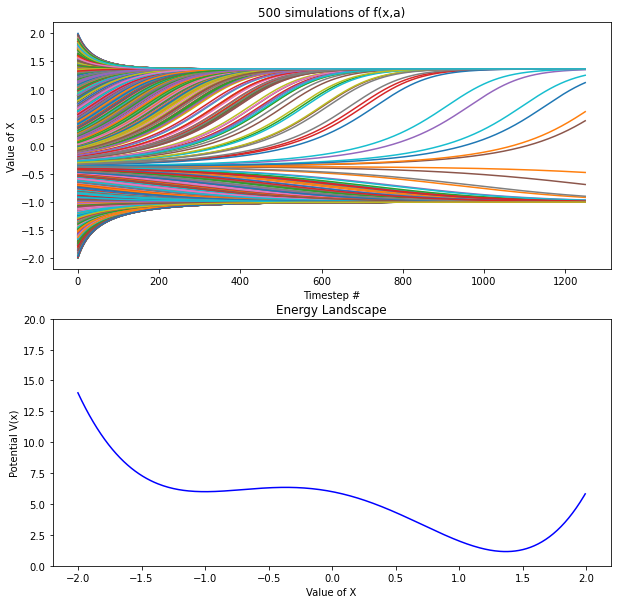

In [16]:
_= bifnsim(a=1, saddle_point=True)

**2d)** Ok, lets try simulating the system with $a=2$.

Whoa, sure looks different. It appears that our attractor that codes for the "left" choice disappeared! Now, the system always chooses "right." A bifurcation? We could try finding the fixed points, and checking their stability (you should try this if you have time). However, the math involves roots of a cubic polynomial, and your TA doesn't want to make you do algebra. Instead, we can compute the roots numerically using the `np.roots` function. You can read the documentation for `np.roots` [here](https://numpy.org/doc/stable/reference/generated/numpy.roots.html)
- How many fixed points do we have now? **(1 point)**

<font color="red">It seems like there is a single stable fixed point.

$$f(x,a=2) = -4x^3 +4x +4 =0\\
x ~= 1.33 \\
\frac{df}{dx} = -12x^2 +4 =0\\
\frac{df}{dx}(x= 1.33, a=2) = -12*(1.3)^2 +4 ~= -16 <0 \text{ (stable)}$$

    
</font>


- Where are the fixed points with respect to the energy landscape, relative to nearby points?  **(1 point)**

<font color="red"> The fixed point (x~=1.3) is at the right 'valley'.</font>

- Are these fixed points stable or unstable? **(1 point)**

<font color="red"> This is a stable fixed point.</font>

- Using `np.roots` as shown below, check the number and location of fixed points for $a=1$ as well. **(1 point)**

<font color="red"> Done above. </font>


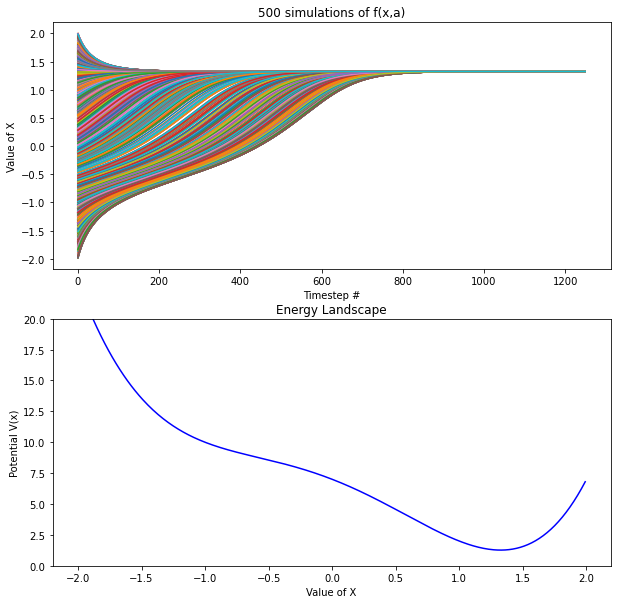

In [17]:
_= bifnsim(a=2)

In [18]:
# Compute roots for a=2
a=2
roots = np.roots([-4,0,8-2*a,2*a])
roots = np.real(roots[np.imag(roots) == 0]) # take only real roots
print(f"The fixed points of this system for a = {a} are {roots}")

The fixed points of this system for a = 2 are [1.32471796]


**2e)** How did we lose an attractor? Let's vary $a$ systematically from $-4$ to 4 , find the fixed points, and see where the attractor disappears. Use the function `bifnDiagram`
which plots a **bifurcation diagram**. Each vertical slice displays the number and location of fixed points for that value of $a$ (which are computed using `np.roots`. Check to make sure it agrees with the simulation for $a=0, a=1$, and $a=2$.
- Change the function `bifnDiagram` and plot red circles at the location of all the fixed points for $a=0,1,2$. Use `plt.scatter(a, fixed_point_of_a, color="red")` where you fill in `a` and `fixed_point_of_a`. **(1 point)**

<font color="red"> done </font>

- Which points are the "left" attractors, which are the "right" attractors, which are the unstable points? **(1 point)**

<font color="red"> See legend below. Right (left) point are still of positive (negative) value (now on the y axis) </font>



In [19]:
roots = lambda a: np.roots([-4,0,8-2*a,2*a])
roots_vals ={}
roots_vals[0] =  np.real(roots(0)[np.imag(roots(0)) == 0])
roots_vals[1] =  np.real(roots(1)[np.imag(roots(1)) == 0])
roots_vals[2] =  np.real(roots(2)[np.imag(roots(2)) == 0])


derivative = lambda a, x: -12*(x**2) +(8-a) > 0

derivative_vals = {}

derivative_vals[0]= [derivative(0,i) for i in roots_vals[0]]
derivative_vals[1]= [derivative(1,i) for i in roots_vals[1]]
derivative_vals[2]= [derivative(2,i) for i in roots_vals[2]]


/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:138: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


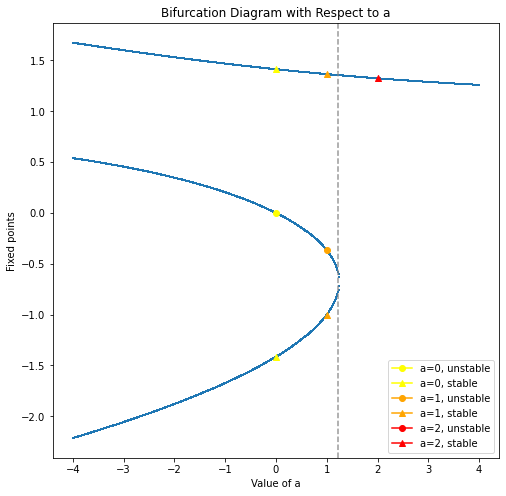

In [20]:
from matplotlib.lines import Line2D

def bifnDiagram(avals):
    # Function Definitions
    f = lambda x, a: -4*x**3 + (8-2*a)*x + 2*a
    V = lambda x, a: x**4 - 4*x**2 + a*(x-1)**2 + 5

    fixed_points = []
    for a in avals:
        p = [-4, 0, 8-2*a, 2*a]
        roots = np.roots(p)
        roots = roots[np.imag(roots) == 0]
        [fixed_points.append([a, root]) for root in roots]
    avals, roots = (zip(*fixed_points))


    fig, (ax0) = plt.subplots(1, figsize=(8,8))
    ax0.scatter(avals, roots, marker="+", s=5)
    ax0.set_xlabel('Value of a')
    ax0.set_ylabel('Fixed points')
    ax0.set_title('Bifurcation Diagram with Respect to a')

    colors = ['yellow', 'orange','red']
    markers = ['^', 'o']
    for a in [0,1,2]:
        a_vals = roots_vals[a]
        x_vals = a*np.ones_like(a_vals)
        color = colors[a]
        for a_val, x_val, d_val in zip(a_vals, x_vals, derivative_vals[a]):
            plt.scatter(x_val, a_val, marker = markers[int(d_val)],
                color=color)
        
        
    legend_elements = [Line2D([0], [0], color=colors[0], marker='o', label='a=0, unstable'),
                       Line2D([0], [0], color=colors[0], marker='^', label='a=0, stable'),
                       
                       Line2D([0], [0], color=colors[1], marker='o', label='a=1, unstable'),
                       Line2D([0], [0], color=colors[1], marker='^', label='a=1, stable'),
                       
                       Line2D([0], [0], color=colors[2], marker='o', label='a=2, unstable'),
                       Line2D([0], [0], color=colors[2], marker='^', label='a=2, stable'),
                   ]
    
    plt.legend(handles=legend_elements)
    plt.axvline(1.214, color='grey', linestyle='--',alpha=0.8,label='a ~=1.4' )

    plt.show()


bifnDiagram(np.arange(-4,4,0.01))

**2f)** You'll notice that around $a=1.214$ both the unstable point and one of the attractors disappear. This is called a **Saddle-Node bifurcation**. Some unstable points are called **saddles**, and some attractors are called **nodes**. The technical definitions are unimportant right now. In a saddle-node bifurcation, a saddle and a node annihilate each other. Simulate the system with $a$ near the bifurcation using `bifnsim`.
- What happens to the simulations? **(1 point)**


<font color="red"> When $a=\sqrt{2}$ the simulation becomes less accurate </font>



- What happens to the energy landscape? **(1 point)**

<font color="red"> (1) It tilts towards the right (2) the left side has a slight plato instead a stablity fixed point. This results in the lack of decision from points starting at the region.</font>


- What happens to "left" choices on either side of the bifurcation, i.e. for $a$ less than 1.214 and for $a$ greater than 1.214? **(1 point)**

<font color="red"> a<1.214 reintroduces the left stable point and a>1.214 tilts the graph towards a single stable point on the right </font>

- What values of $a$ result in both left and right choices? **(1 point)**

<font color="red"> $a\sim<\sqrt{2}$ </font>

- What values of $a$ result in completely accurate sorting of the initial condition into left and right choices? **(1 point)**

<font color="red"> a=0. see plot below (marked with a red line). </font>

- How does accuracy vary as $a$ goes from 0 to $1.24$ ? **(1 point)**

<font color="red"> It decreases. See highlighted area in the plot below. </font>


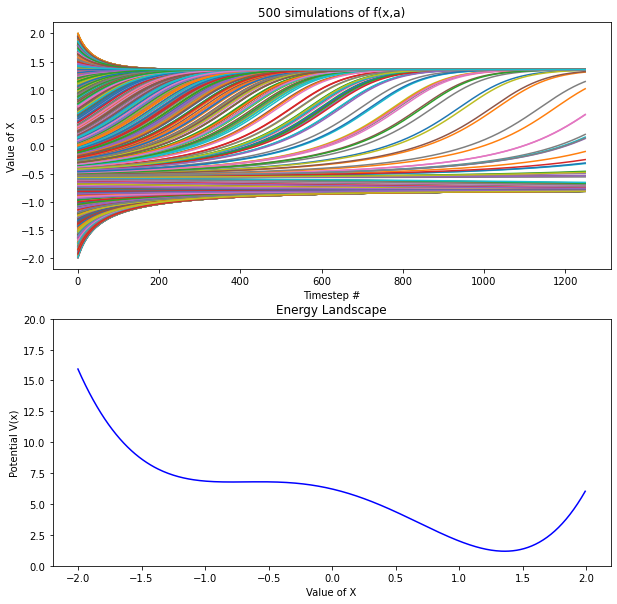

In [21]:
_= bifnsim(a=1.214)

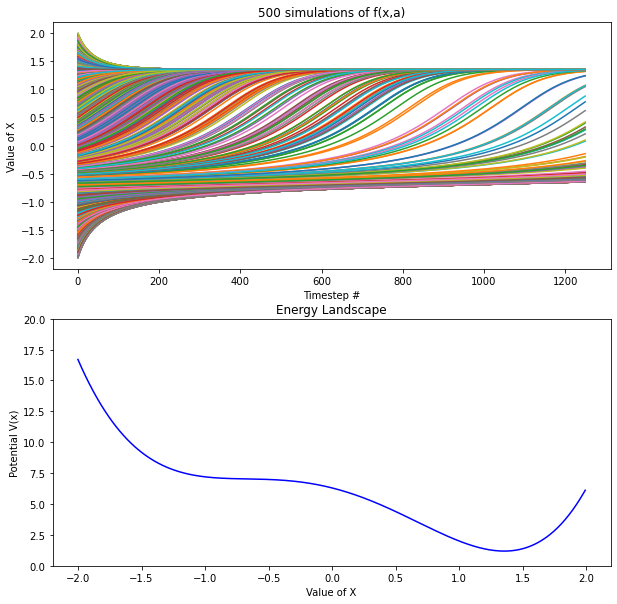

In [22]:
_= bifnsim(a=1.3)

In [23]:
accuracy = []
left_choice = []
right_choice = []
a_range = np.linspace(-2,2,31)
for a in a_range:
    x = bifnsim(a, False, False)
    acc = np.sum(np.where(x[:,0]<0, 1, 2) == np.where(x[:,-1]<0, 1, 2))/1000
    accuracy.append(acc)
    left_choice.append(np.sum(x[:,-1]<1)/1000)
    right_choice.append(np.sum(x[:,-1]>1)/1000)


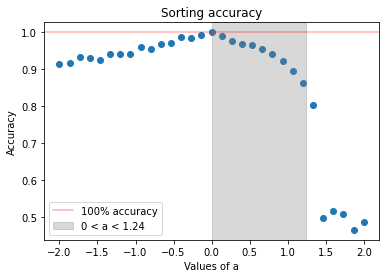

In [24]:
plt.title('Sorting accuracy')
plt.scatter(a_range,accuracy)
plt.axhline(1, color='red', alpha=0.3, label='100% accuracy')
plt.axvspan(0, 1.24, color='grey', alpha=0.3, label='0 < a < 1.24')
plt.xlabel('Values of a')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

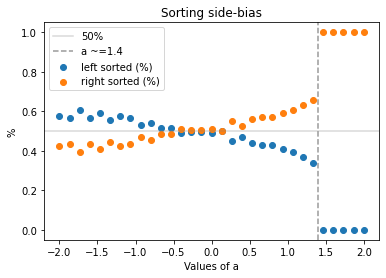

In [25]:
plt.title('Sorting side-bias')

plt.axhline(.5, color='grey', alpha=0.3, label='50%')
plt.axvline(1.4, color='grey', linestyle='--',alpha=0.8,label='a ~=1.4' )

plt.scatter(a_range,left_choice, label='left sorted (%)') 
plt.scatter(a_range,right_choice, label='right sorted (%)') 
plt.xlabel('Values of a')
plt.ylabel('%')
plt.legend()
plt.show()

**2g)** In our model, a bifurcation happened when we changed the parameter $a$. List two possible biological variables or experimental manipulations that $a$ might represent in the context of a left/right memory task. Remember that $x_{0}$ is the cue that says to go left or right, and $a$ is a different variable. **(2 points)**

<font color="red"> *a* seems to reflect some cognitive bias, either from external stimuli (priming) or internal decision made (history-based stay bias). 

</font>
